# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
#import piexif

import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import pycocotools
%matplotlib inline 
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14682698721426259806, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9538482996
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16310766623702662219
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
#import keras
#import tensorflow as tf
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)


## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    #IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512, 768)  # anchor side in pixels
    BACKBONE_STRIDES = [4, 8, 16, 32, 64,128]

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 10
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64, 128]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE    

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
def seperate_x_and_y_points(poly):   
    poly = ''.join(poly);
    a = poly.split(',')            
    x_points = a[0::2]            
    y_points = a[1::2]
    x_points = list(map(int, x_points))
    y_points = list(map(int, y_points))
    return x_points, y_points

class BalloonDataset(utils.Dataset):
    whichDataSetToLoad = ''
        
    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
       # assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "instances.json")))        
       # print(dataset_dir)
        print()
        
        for  i in range(len(annotations['images'])):
            polygon = list(dict())
            polygon = [{'name': 'polygon', 'all_points_x': [], 'all_points_y': []}]
            polygon[0]['name'] ='text'
            
            #print(polygon)
            file_name = annotations['images'][i]['file_name']
            #print(file_name)
            width = int(annotations['images'][i]['width'])
            height = int(annotations['images'][i]['height'])
           # print(file_name, width, height)
        
            if(self.whichDataSetToLoad != 'ground_truth'):            
                image_path = os.path.join(dataset_dir, file_name)+ '.jpg'  
                #print(image_path)
            if(self.whichDataSetToLoad == 'ground_truth'):   
                image_path = os.path.join(dataset_dir, file_name)+ '.png'  
            #print(image_path)
            segmentation = annotations['annotations'][i]['segmentation']
            polygons = []
            for poly in segmentation:   
                x_points, y_points = seperate_x_and_y_points(poly)                          
                polygon = {'name': 'polygon', 'all_points_x': [], 'all_points_y': []}
                polygon['name'] ='text'
                polygon['all_points_x'] = x_points
                polygon['all_points_y'] = y_points         
                polygons.append(polygon)
            #print(polygons)
            self.add_image(
                    "balloon",
                    image_id=file_name,  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons)
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
        


In [7]:
# Training dataset
dataset_train = BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_train.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "train")
dataset_train.prepare()

# Validation dataset
dataset_val =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_val.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "val")
dataset_val.prepare()


# Test dataset
dataset_test =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_test.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "test")
dataset_test.prepare()



In [8]:
'''
# Training dataset
dataset_train_gt = BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_train_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "train")
dataset_train_gt.prepare()

# Validation dataset
dataset_val_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_val_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "val")
dataset_val_gt.prepare()


# Test dataset
dataset_test_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_test_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "test")
dataset_test_gt.prepare()

'''

'\n# Training dataset\ndataset_train_gt = BalloonDataset()\ndataset_train_gt.whichDataSetToLoad = \'ground_truth\'\ndataset_train_gt.load_balloon(\'/home/harsh/Mask_RCNN/datasets/documents/ground_truth/\', "train")\ndataset_train_gt.prepare()\n\n# Validation dataset\ndataset_val_gt =  BalloonDataset()\ndataset_train_gt.whichDataSetToLoad = \'ground_truth\'\ndataset_val_gt.load_balloon(\'/home/harsh/Mask_RCNN/datasets/documents/ground_truth/\', "val")\ndataset_val_gt.prepare()\n\n\n# Test dataset\ndataset_test_gt =  BalloonDataset()\ndataset_train_gt.whichDataSetToLoad = \'ground_truth\'\ndataset_test_gt.load_balloon(\'/home/harsh/Mask_RCNN/datasets/documents/ground_truth/\', "test")\ndataset_test_gt.prepare()\n\n'

##  Loading ground truth mask to show that masks are loading correctly 

In [9]:
'''
# Loading ground truth mask to show that masks are loading correctly
# Load and display random samples
print(dataset_train_gt.num_images)
image_ids = np.random.choice(dataset_train_gt.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train_gt.load_image(image_id)
    mask, class_ids = dataset_train_gt.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train_gt.class_names)
    '''

'\n# Loading ground truth mask to show that masks are loading correctly\n# Load and display random samples\nprint(dataset_train_gt.num_images)\nimage_ids = np.random.choice(dataset_train_gt.image_ids, 10)\nprint(image_ids)\nfor image_id in image_ids:\n    image = dataset_train_gt.load_image(image_id)\n    mask, class_ids = dataset_train_gt.load_mask(image_id)\n    print(class_ids)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train_gt.class_names)\n    '

##  Loading Training Images mask to show that masks are loading correctly 

In [10]:
'''
# Load and display random samples
print(dataset_train.num_images)
image_ids = np.random.choice(dataset_train.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    '''

'\n# Load and display random samples\nprint(dataset_train.num_images)\nimage_ids = np.random.choice(dataset_train.image_ids, 10)\nprint(image_ids)\nfor image_id in image_ids:\n    image = dataset_train.load_image(image_id)\n    mask, class_ids = dataset_train.load_mask(image_id)\n    print(class_ids)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)\n    '

In [11]:
# Applying Augmentation

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


seq = iaa.Sometimes(0.833, iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.3)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)) # apply augmenters in random order

## Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 1


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=60, 
            layers='heads', augmentation= seq)



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190828T1013/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/60
  77/1000 [=>............................] - ETA: 19:01 - loss: 3.3868 - rpn_class_loss: 0.6900 - rpn_bbox_loss: 1.5399 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.7053 - mrcnn_mask_loss: 0.4043

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  79/1000 [=>............................] - ETA: 18:44 - loss: 3.3522 - rpn_class_loss: 0.6797 - rpn_bbox_loss: 1.5137 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.7021 - mrcnn_mask_loss: 0.4087

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


  80/1000 [=>............................] - ETA: 18:36 - loss: 3.3372 - rpn_class_loss: 0.6745 - rpn_bbox_loss: 1.5009 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.7026 - mrcnn_mask_loss: 0.4105

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

  81/1000 [=>............................] - ETA: 18:28 - loss: 3.3558 - rpn_class_loss: 0.6699 - rpn_bbox_loss: 1.5072 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.7188 - mrcnn_mask_loss: 0.4117

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 238/1000 [======>.......................] - ETA: 11:00 - loss: 3.0605 - rpn_class_loss: 0.4070 - rpn_bbox_loss: 1.3543 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.6780 - mrcnn_mask_loss: 0.5325

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 242/1000 [======>.......................] - ETA: 10:53 - loss: 3.0680 - rpn_class_loss: 0.4075 - rpn_bbox_loss: 1.3603 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.6775 - mrcnn_mask_loss: 0.5343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 244/1000 [======>.......................] - ETA: 10:50 - loss: 3.0722 - rpn_class_loss: 0.4087 - rpn_bbox_loss: 1.3633 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.6769 - mrcnn_mask_loss: 0.5354

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 245/1000 [======>.......................] - ETA: 10:48 - loss: 3.0724 - rpn_class_loss: 0.4084 - rpn_bbox_loss: 1.3641 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.6763 - mrcnn_mask_loss: 0.5358

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


 246/1000 [======>.......................] - ETA: 10:46 - loss: 3.0734 - rpn_class_loss: 0.4077 - rpn_bbox_loss: 1.3659 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5360

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 247/1000 [======>.......................] - ETA: 10:45 - loss: 3.0725 - rpn_class_loss: 0.4070 - rpn_bbox_loss: 1.3657 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.5366

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 312/1000 [========>.....................] - ETA: 9:14 - loss: 2.9590 - rpn_class_loss: 0.3616 - rpn_bbox_loss: 1.3336 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.6402 - mrcnn_mask_loss: 0.5340

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 314/1000 [========>.....................] - ETA: 9:12 - loss: 2.9633 - rpn_class_loss: 0.3622 - rpn_bbox_loss: 1.3362 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.6417 - mrcnn_mask_loss: 0.5335

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


 315/1000 [========>.....................] - ETA: 9:11 - loss: 2.9645 - rpn_class_loss: 0.3623 - rpn_bbox_loss: 1.3374 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.6421 - mrcnn_mask_loss: 0.5331

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 318/1000 [========>.....................] - ETA: 9:07 - loss: 2.9647 - rpn_class_loss: 0.3616 - rpn_bbox_loss: 1.3401 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.6412 - mrcnn_mask_loss: 0.5316

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 321/1000 [========>.....................] - ETA: 9:03 - loss: 2.9623 - rpn_class_loss: 0.3600 - rpn_bbox_loss: 1.3424 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.6398 - mrcnn_mask_loss: 0.5294

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 503/1000 [==============>...............] - ETA: 6:12 - loss: 2.7888 - rpn_class_loss: 0.2999 - rpn_bbox_loss: 1.2898 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.5938 - mrcnn_mask_loss: 0.4952

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 504/1000 [==============>...............] - ETA: 6:12 - loss: 2.7878 - rpn_class_loss: 0.2997 - rpn_bbox_loss: 1.2895 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.5935 - mrcnn_mask_loss: 0.4950

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 505/1000 [==============>...............] - ETA: 6:11 - loss: 2.7877 - rpn_class_loss: 0.2995 - rpn_bbox_loss: 1.2893 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.5936 - mrcnn_mask_loss: 0.4952

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 506/1000 [==============>...............] - ETA: 6:10 - loss: 2.7874 - rpn_class_loss: 0.2994 - rpn_bbox_loss: 1.2890 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.5936 - mrcnn_mask_loss: 0.4954

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 510/1000 [==============>...............] - ETA: 6:07 - loss: 2.7843 - rpn_class_loss: 0.2990 - rpn_bbox_loss: 1.2865 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.5934 - mrcnn_mask_loss: 0.4958

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 620/1000 [=================>............] - ETA: 4:39 - loss: 2.6987 - rpn_class_loss: 0.2720 - rpn_bbox_loss: 1.2505 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.4851

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 623/1000 [=================>............] - ETA: 4:37 - loss: 2.6968 - rpn_class_loss: 0.2710 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.5713 - mrcnn_mask_loss: 0.4843

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 624/1000 [=================>............] - ETA: 4:36 - loss: 2.6976 - rpn_class_loss: 0.2708 - rpn_bbox_loss: 1.2519 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.5713 - mrcnn_mask_loss: 0.4841

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 625/1000 [=================>............] - ETA: 4:35 - loss: 2.6983 - rpn_class_loss: 0.2706 - rpn_bbox_loss: 1.2531 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.5712 - mrcnn_mask_loss: 0.4840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 632/1000 [=================>............] - ETA: 4:30 - loss: 2.6974 - rpn_class_loss: 0.2694 - rpn_bbox_loss: 1.2562 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.5697 - mrcnn_mask_loss: 0.4827

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 634/1000 [==================>...........] - ETA: 4:29 - loss: 2.6973 - rpn_class_loss: 0.2694 - rpn_bbox_loss: 1.2570 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.5693 - mrcnn_mask_loss: 0.4823

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 659/1000 [==================>...........] - ETA: 4:11 - loss: 2.6888 - rpn_class_loss: 0.2684 - rpn_bbox_loss: 1.2517 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.5674 - mrcnn_mask_loss: 0.4817

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 661/1000 [==================>...........] - ETA: 4:10 - loss: 2.6880 - rpn_class_loss: 0.2683 - rpn_bbox_loss: 1.2508 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.5672 - mrcnn_mask_loss: 0.4816

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 662/1000 [==================>...........] - ETA: 4:09 - loss: 2.6876 - rpn_class_loss: 0.2682 - rpn_bbox_loss: 1.2503 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.5671 - mrcnn_mask_loss: 0.4816

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 663/1000 [==================>...........] - ETA: 4:09 - loss: 2.6872 - rpn_class_loss: 0.2681 - rpn_bbox_loss: 1.2497 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4817

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 666/1000 [==================>...........] - ETA: 4:07 - loss: 2.6851 - rpn_class_loss: 0.2680 - rpn_bbox_loss: 1.2471 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.4820

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 669/1000 [===================>..........] - ETA: 4:04 - loss: 2.6816 - rpn_class_loss: 0.2679 - rpn_bbox_loss: 1.2441 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.5662 - mrcnn_mask_loss: 0.4820

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 869/1000 [=========================>....] - ETA: 1:34 - loss: 2.5221 - rpn_class_loss: 0.2360 - rpn_bbox_loss: 1.1802 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.5242 - mrcnn_mask_loss: 0.4514

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 871/1000 [=========================>....] - ETA: 1:32 - loss: 2.5214 - rpn_class_loss: 0.2358 - rpn_bbox_loss: 1.1786 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.5243 - mrcnn_mask_loss: 0.4518

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 875/1000 [=========================>....] - ETA: 1:29 - loss: 2.5171 - rpn_class_loss: 0.2353 - rpn_bbox_loss: 1.1751 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.5238 - mrcnn_mask_loss: 0.4516

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 876/1000 [=========================>....] - ETA: 1:29 - loss: 2.5155 - rpn_class_loss: 0.2352 - rpn_bbox_loss: 1.1742 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.5235 - mrcnn_mask_loss: 0.4515

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 877/1000 [=========================>....] - ETA: 1:28 - loss: 2.5140 - rpn_class_loss: 0.2350 - rpn_bbox_loss: 1.1733 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.5232 - mrcnn_mask_loss: 0.4513

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 880/1000 [=========================>....] - ETA: 1:26 - loss: 2.5121 - rpn_class_loss: 0.2352 - rpn_bbox_loss: 1.1718 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.4509

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 885/1000 [=========================>....] - ETA: 1:22 - loss: 2.5072 - rpn_class_loss: 0.2351 - rpn_bbox_loss: 1.1689 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.4499

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 928/1000 [==========================>...] - ETA: 51s - loss: 2.4780 - rpn_class_loss: 0.2309 - rpn_bbox_loss: 1.1585 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.5133 - mrcnn_mask_loss: 0.4459

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 930/1000 [==========================>...] - ETA: 50s - loss: 2.4761 - rpn_class_loss: 0.2305 - rpn_bbox_loss: 1.1572 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.5132 - mrcnn_mask_loss: 0.4458

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 932/1000 [==========================>...] - ETA: 48s - loss: 2.4741 - rpn_class_loss: 0.2302 - rpn_bbox_loss: 1.1562 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.4457

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 935/1000 [===========================>..] - ETA: 46s - loss: 2.4712 - rpn_class_loss: 0.2297 - rpn_bbox_loss: 1.1550 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5122 - mrcnn_mask_loss: 0.4452

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 936/1000 [===========================>..] - ETA: 45s - loss: 2.4695 - rpn_class_loss: 0.2295 - rpn_bbox_loss: 1.1540 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5119 - mrcnn_mask_loss: 0.4450

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 937/1000 [===========================>..] - ETA: 44s - loss: 2.4693 - rpn_class_loss: 0.2294 - rpn_bbox_loss: 1.1543 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.4448

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 938/1000 [===========================>..] - ETA: 44s - loss: 2.4691 - rpn_class_loss: 0.2293 - rpn_bbox_loss: 1.1544 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5117 - mrcnn_mask_loss: 0.4446

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 946/1000 [===========================>..] - ETA: 38s - loss: 2.4634 - rpn_class_loss: 0.2281 - rpn_bbox_loss: 1.1519 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.5109 - mrcnn_mask_loss: 0.4436

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


1000/1000 [==============================] - 734s 734ms/step - loss: 2.4475 - rpn_class_loss: 0.2235 - rpn_bbox_loss: 1.1501 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.5033 - mrcnn_mask_loss: 0.4407 - val_loss: 3.1291 - val_rpn_class_loss: 0.2718 - val_rpn_bbox_loss: 1.7661 - val_mrcnn_class_loss: 0.0543 - val_mrcnn_bbox_loss: 0.4448 - val_mrcnn_mask_loss: 0.5922
Epoch 2/60
  53/1000 [>.............................] - ETA: 9:20 - loss: 1.7839 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.4109

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  64/1000 [>.............................] - ETA: 9:17 - loss: 1.8175 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.7272 - mrcnn_class_loss: 0.1730 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4253

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  70/1000 [=>............................] - ETA: 9:16 - loss: 1.8182 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.1734 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.4190

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  75/1000 [=>............................] - ETA: 9:14 - loss: 1.8510 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.7497 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.4196

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  76/1000 [=>............................] - ETA: 9:14 - loss: 1.8569 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.7564 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.4188

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  81/1000 [=>............................] - ETA: 9:12 - loss: 1.9043 - rpn_class_loss: 0.1168 - rpn_bbox_loss: 0.7970 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.4291

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  87/1000 [=>............................] - ETA: 9:09 - loss: 1.9106 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.8150 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.4242

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 190/1000 [====>.........................] - ETA: 8:13 - loss: 1.9173 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.9011 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.3826

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 200/1000 [=====>........................] - ETA: 8:08 - loss: 1.9176 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.9009 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.3809

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 207/1000 [=====>........................] - ETA: 8:03 - loss: 1.9243 - rpn_class_loss: 0.1121 - rpn_bbox_loss: 0.9139 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.3772

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 211/1000 [=====>........................] - ETA: 8:01 - loss: 1.9309 - rpn_class_loss: 0.1115 - rpn_bbox_loss: 0.9262 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.3747

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 214/1000 [=====>........................] - ETA: 7:59 - loss: 1.9432 - rpn_class_loss: 0.1120 - rpn_bbox_loss: 0.9383 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.3478 - mrcnn_mask_loss: 0.3743

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 218/1000 [=====>........................] - ETA: 7:56 - loss: 1.9521 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.9531 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.3731

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 219/1000 [=====>........................] - ETA: 7:56 - loss: 1.9572 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.9566 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.3735

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 224/1000 [=====>........................] - ETA: 7:53 - loss: 1.9673 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 0.9661 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.3740

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 232/1000 [=====>........................] - ETA: 7:48 - loss: 1.9709 - rpn_class_loss: 0.1127 - rpn_bbox_loss: 0.9722 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.3737

In [ ]:
# Save weights head layer
'''
model_path = os.path.join(MODEL_DIR, "head_1.h5")
model.keras_model.save_weights(model_path)
'''

In [ ]:
 '''
    # Training - Stage 2
        # Finetune layers from ResNet stage 4 and up
        print("Fine tune Resnet stage 4 and up")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=150,
                    layers='4+',
                    augmentation=seq)
       '''             


In [ ]:
'''
model_path = os.path.join(MODEL_DIR, "4.h5")
model.keras_model.save_weights(model_path)
'''

In [ ]:
'''
    # Training - Stage 3
        # Fine tune all layers
        print("Fine tune all layers")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE / 10,
                    epochs=60,
                    layers='all',
                    augmentation=seq)
                    '''

In [ ]:
'''
model_path = os.path.join(MODEL_DIR, ".h5")
model.keras_model.save_weights(model_path)
'''

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
'''
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")
model.keras_model.save_weights(model_path)
'''

## Detection

In [14]:

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

#model_path = model.find_last()
model_path = os.path.join(MODEL_DIR, "head.h5")

#model_path = '/home/harsh/Mask_RCNN/logs/shapes20190824T0132/mask_rcnn_shapes_0150.h5'
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  /home/harsh/Mask_RCNN/logs/head.h5


In [15]:

import skimage
from skimage import data, io


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  237.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 3920.00000  float64
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:  135.00000  max:  639.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


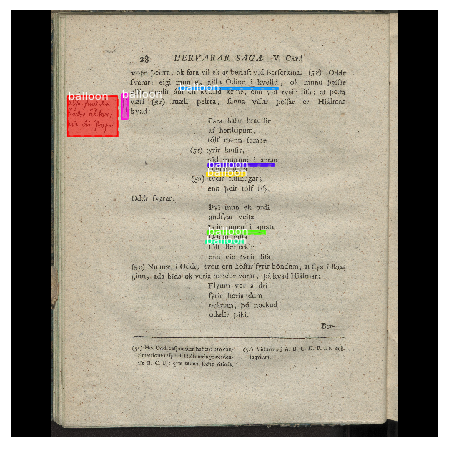

In [16]:

# Test on a random image of validation
#image_id = random.choice(dataset_train.image_ids)
image_id =3
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  237.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  113.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 262080, 4)        min:   -0.53085  max:    1.40573  float32


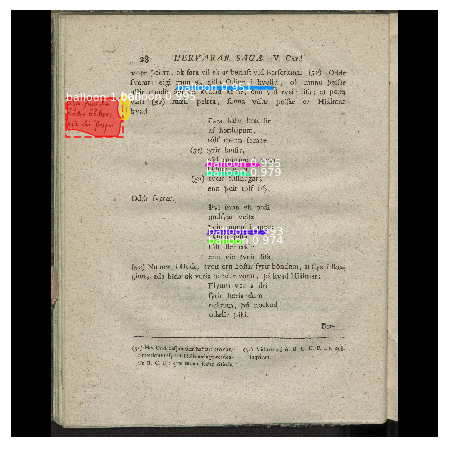

In [17]:

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                           dataset_val.class_names, r['scores'], ax=get_ax())

In [18]:

def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps


def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

## Evaluation

GT Image


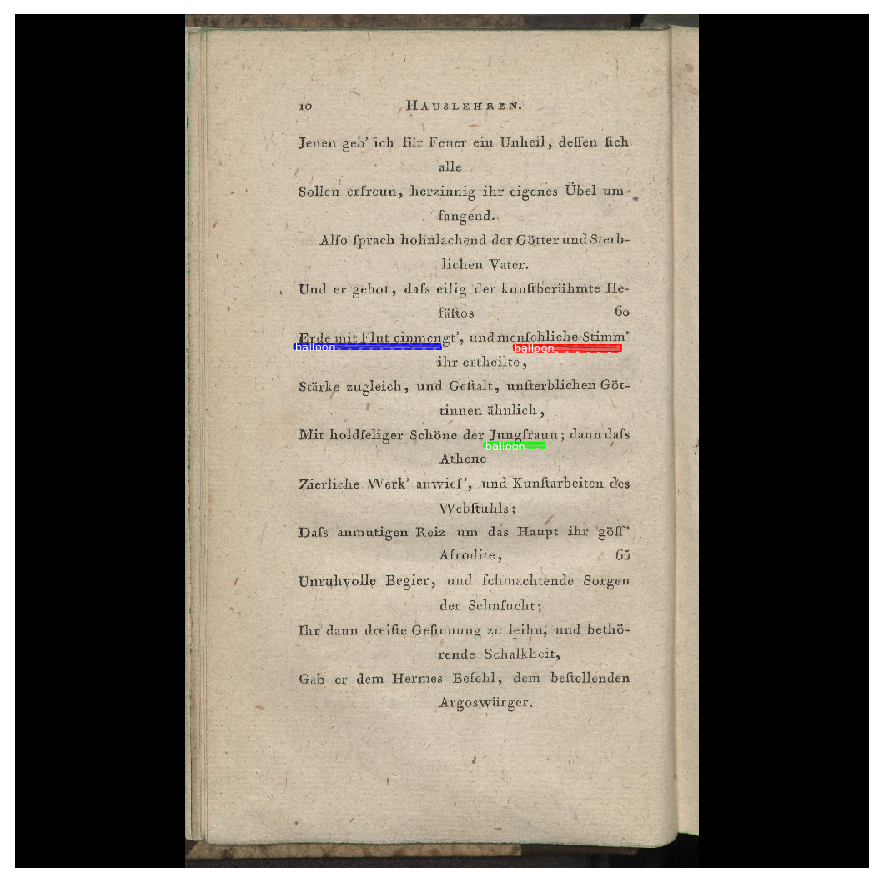

Predicted Image
[[395 594 403 724]
 [395 334 403 517]
 [512 566 520 636]]


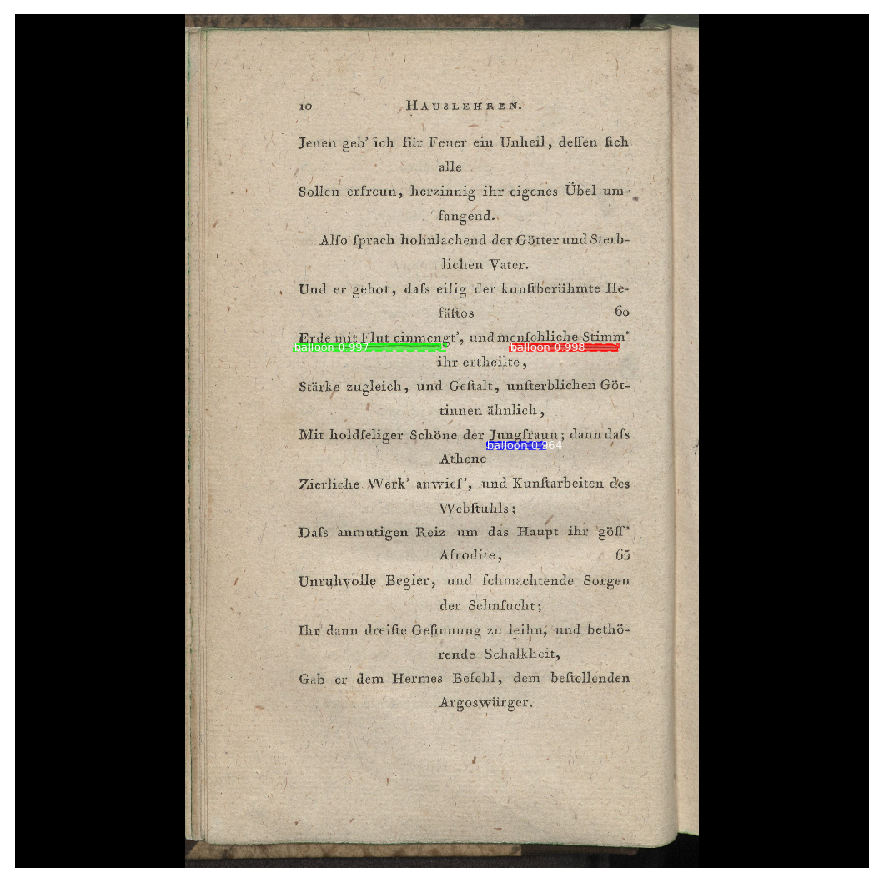

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3
Mask IOU
0.8464005589485168
bb IOU
0.927861591218721
GT Image


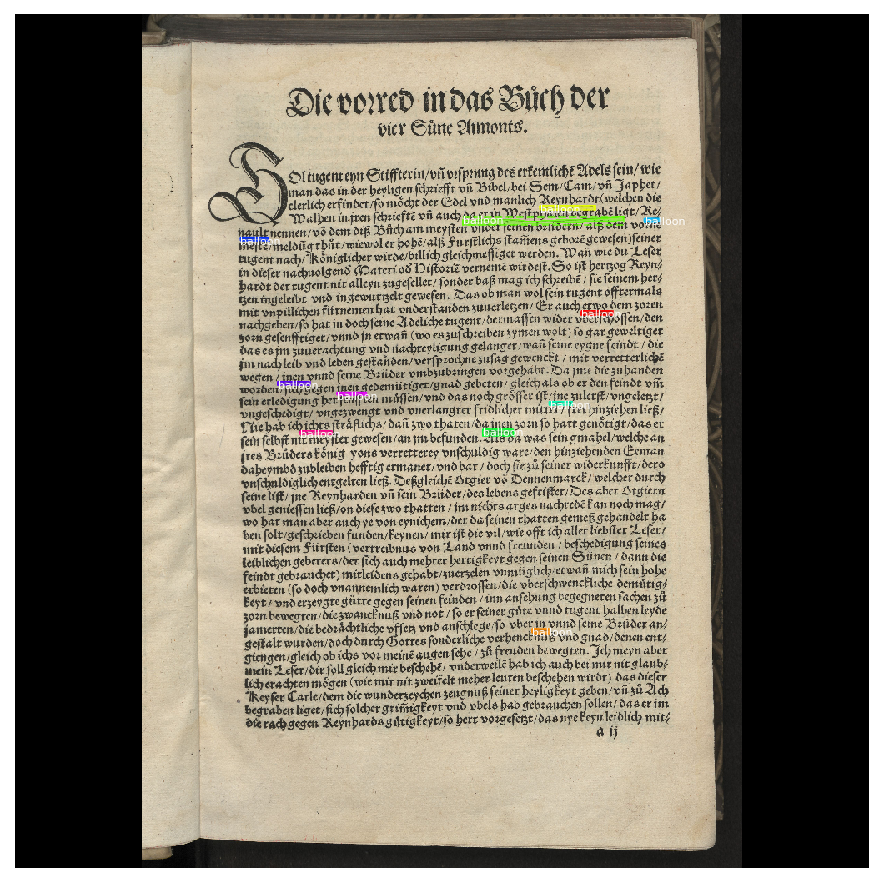

Predicted Image
[[245 536 251 615]
 [142 235 284 329]
 [497 561 504 602]
 [243 560 251 723]]


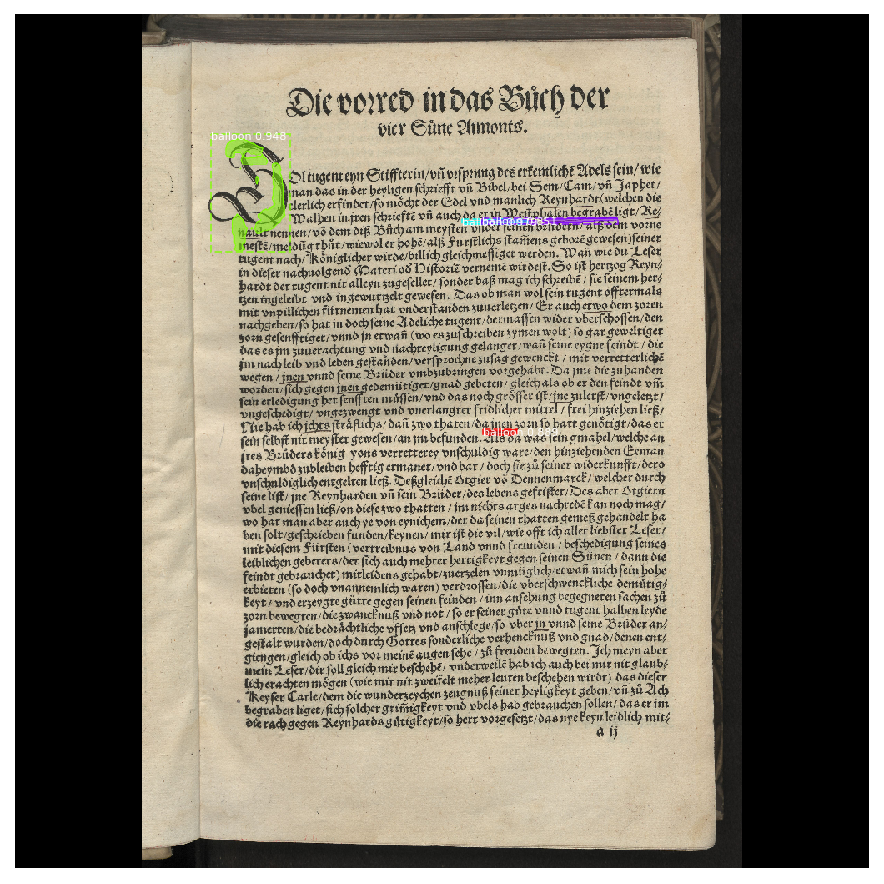

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4
Mask IOU
0.3357846955768764
bb IOU
0.36557851388667867
GT Image


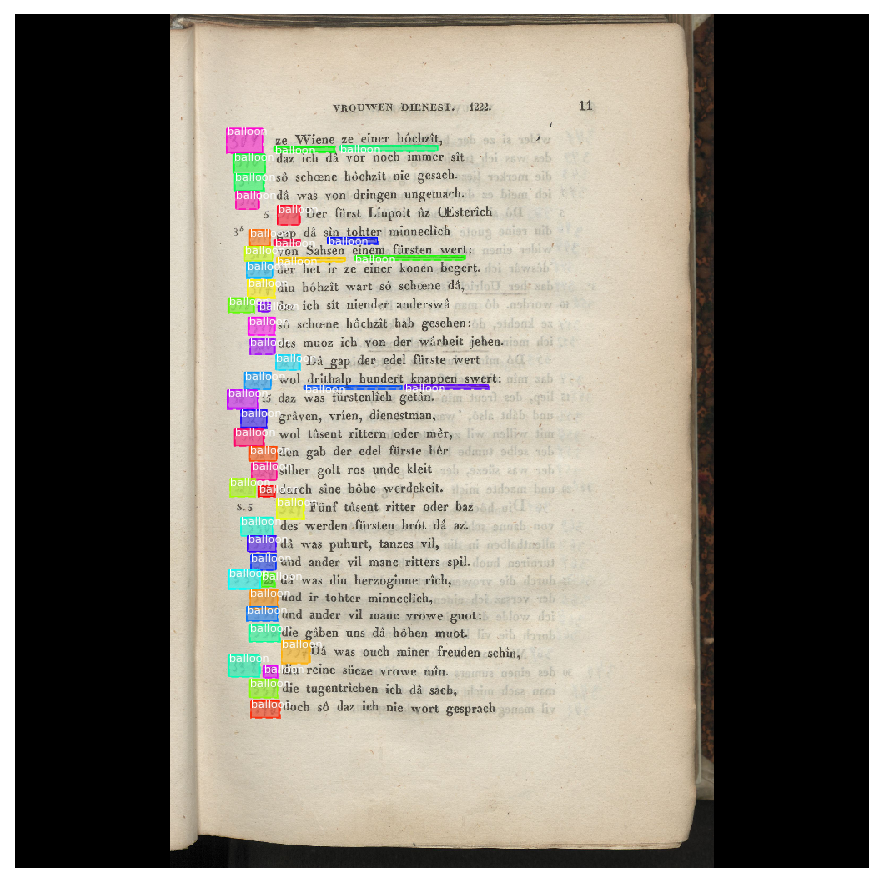

Predicted Image
[[156 316 162 504]
 [583 313 604 347]
 [444 343 450 464]
 [514 278 540 315]
 [624 279 643 316]
 [138 251 162 299]
 [536 279 556 313]
 [274 273 298 309]
 [158 311 163 382]
 [290 315 295 398]
 [646 280 667 314]
 [557 258 578 293]
 [254 273 277 306]
 [290 331 295 559]
 [604 273 627 313]
 [187 260 208 296]
 [472 266 495 304]
 [268 310 274 450]
 [444 477 449 569]
 [495 262 515 302]
 [ 94 673 123 702]]


KeyboardInterrupt: 

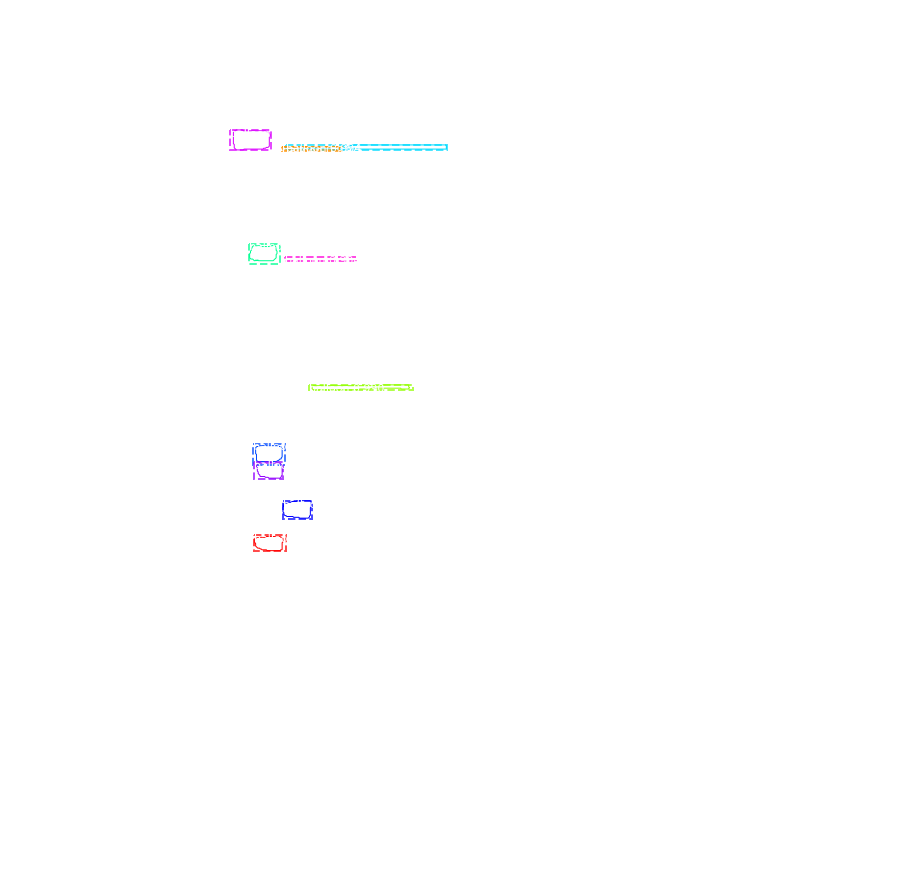

In [20]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
#image_ids = np.random.choice(dataset_test.image_ids, 10)
image_ids =  dataset_test.image_ids
APs = []
IOU = 0
MSum = 0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]    
    print('GT Image')
    visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names)
    
    print('Predicted Image')
    print(np.array(r['rois']))
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'])
    
   
    
    # Compute IOU for masks
    mask_iou = compute_overlaps_masks(r['masks'], gt_mask) 
    mask_sum = 0
    for a in mask_iou:
        if(a != []):
            mask_sum += max(a)
   # print(mask_iou)
    if(mask_iou.shape[0]!=0):
        print(len(mask_iou))
        MSum += mask_sum/mask_iou.shape[0]
    print('Mask IOU')
    if(mask_iou.shape[0]!=0):
        print(mask_sum/mask_iou.shape[0])
    #print('\n')
    #print('IOU for Masks \n\n')
    #print(mask_iou)
    
    # Compute IOU for BB
    #print("predition bouding box")
    r['rois'].sort()
   # print(r['rois'])
    
    gt_bbox.sort()

    #print("Ground Truth bouding box")
   # print(gt_bbox)

    IoU_sum =0
    bb_iou = compute_overlaps(gt_bbox,  r['rois'])
    for a in bb_iou:
        if(a != []):
            IoU_sum += max(a)
    IOU += IoU_sum/bb_iou.shape[0]
    print('bb IOU')
    print(IoU_sum/bb_iou.shape[0])
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("IoU Bounding Box: ", IOU/dataset_test.num_images)
print("IoU Masks: ",MSum/dataset_test.num_images)


In [ ]:
processes = []
mius = []


processes.append(subprocess.Popen(["java", "-jar", "LayoutAnalysisEvaluator.jar", "-p", prediction_filename, "-gt", gt_path], stdout=subprocess.PIPE))

for p in processes:
    miu = float(p.communicate()[0].splitlines()[0].split()[-1])
    mius.append(miu)

print(mius)
print("average:", np.mean(mius))
return np.mean(mius)


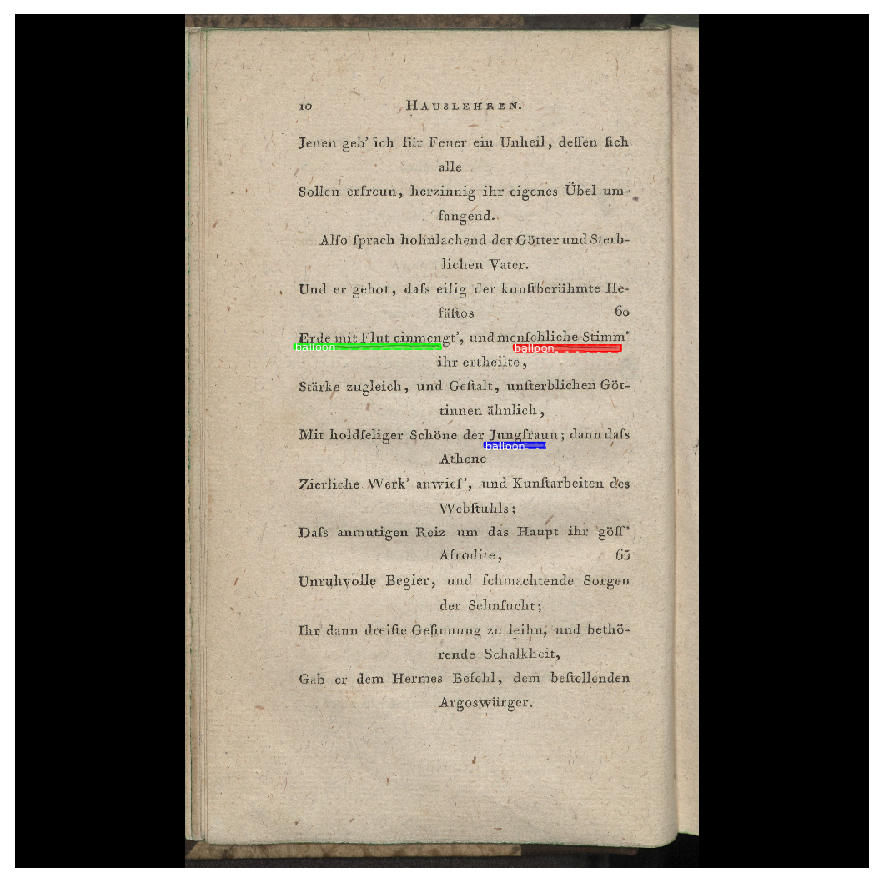

(1024, 1024)
[0.00209]
average: 0.00209


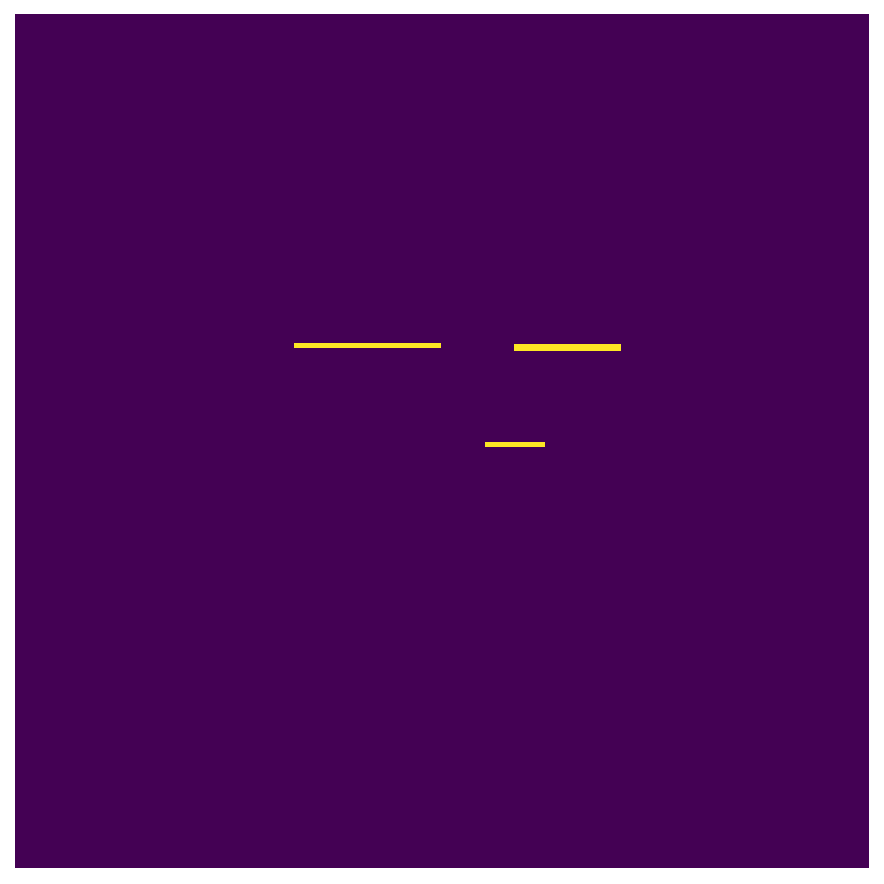

In [120]:

from skimage import color
from skimage import io
from PIL import Image
import numpy as np
import scipy.misc
import subprocess


processes= []
image_ids =  dataset_test.image_ids
APs = []
IOU = 0
MSum = 0
mius = []
for image_id in [0]:    
    image_name = dataset_test.image_info[image_id]['id']+'.png'
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]   
    visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id,dataset_test.class_names)    
    image = np.zeros((1024,1024), dtype=int)
    #print(r['rois'])
    for roi in gt_bbox:        
        y1, x1, y2, x2 = roi
        for i  in range(x1,x2):
            for j  in range(y1,y2):
                image[j,i] = 255
        
    print(image.shape)
    w, h = image.shape
    # Creates PIL image
    #plt.imshow(image, cmap="gray")
    #plt.show()
    
    ax = False
    if not ax:
        _, ax = plt.subplots(1, figsize=(16, 16))
        auto_show = True

    

    # Show area outside image boundaries.
    height, width = image.shape
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')    
    ax.imshow(image.astype(np.uint8))
    
    
    prediction_path = os.path.join(os.getcwd(), "prediction-private")
    if not os.path.isdir(prediction_path):
        os.makedirs(prediction_path)
    prediction_filename = os.path.join(prediction_path, image_name)    
    
    cv2.imwrite(prediction_filename, image)
    
    gt_path = os.path.abspath("../../")
    gt_path = os.path.join(gt_path,'datasets', 'documents', 'ground_truth', 'test')
    gt_path = os.path.join(gt_path, image_name)
   # print(gt_path, prediction_filename)

    jar_dir = os.path.abspath("../../")
    jar_file = os.path.join(jar_dir,'LayoutAnalysisEvaluator.jar')    
    processes.append(subprocess.Popen(["java", "-jar", jar_file, "-p", prediction_filename, "-gt", gt_path], stdout=subprocess.PIPE))
    
    for p in processes:
        miu = float(p.communicate()[0].splitlines()[0].split()[-1])
        mius.append(miu)    
    print(mius)
    print("average:", np.mean(mius))    

    
    



In [116]:
!pwd

/home/harsh/Mask_RCNN/samples/shapes


In [103]:
# Resize the Ground truth to 1024, 1024

from PIL import Image
import os, sys


path = os.path.abspath("../../")
path = os.path.join(path,'datasets', 'documents', 'ground_truth', 'test')
print(path)
dirs = os.listdir( path )

def resize():    
    for item in dirs:     
        filepath = path+'/'+item
        if os.path.isfile(filepath):
            im = Image.open(filepath)
            f, e = os.path.splitext(filepath)
            imResize = im.resize((1024,1024), Image.ANTIALIAS)
            imResize.save(f + '.png')
            

resize()

/home/harsh/Mask_RCNN/datasets/documents/ground_truth/test
